In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
#from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import Analyzer

In [ ]:
# 삼중창 매매 시스템의 두 번째 창에서는 첫 번째 창의 추세 방향
# 과 역행하는 파도를 파악하는 데 오실레이터를 활용한다. 
# 오실레이터는 시장이 하락할 때 매수 기회를 제공하고, 
# 시장이 상승할 때 매도 기회를 제공한다, 
# 즉, 주봉 추세가 상승하고 있을 때 일봉 추세가 하락하면 
# 매수 기회로 본다.

# 주간 히스토그램이 상승하고 있을 때 스토캐스틱이 30 아래로 
# 내려가면 매수하고, 주간 MACD 리스토그램이 하락하고 있을 때 
# 스토캐스틱이 70 위로 올라가면 매도하라고 나와있다.
# 하지만 앞에서 설명했듯이 주간 히스토그램보다 130일 지수 이동평균
# 의 신뢰성이 높기 때문에, 130일 지수이동평균과 스토캐스틱을 함께 
# 사용할 것이다.

In [14]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2021-10-01')

end_date is initialized to '2022-02-02'


In [15]:
ema60 = df.close.ewm(span=60).mean()
ema130 = df.close.ewm(span=130).mean() 
macd = ema60 - ema130
signal = macd.ewm(span=45).mean() 
macdhist = macd - signal

In [16]:
df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal,
    macdhist=macdhist).dropna()
df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number','open','high','low','close']]

In [17]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()      # ①
ndays_low = df.low.rolling(window=14, min_periods=1).min()        # ②
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100  # ③
slow_d= fast_k.rolling(window=3).mean()                           # ④
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()             # ⑤

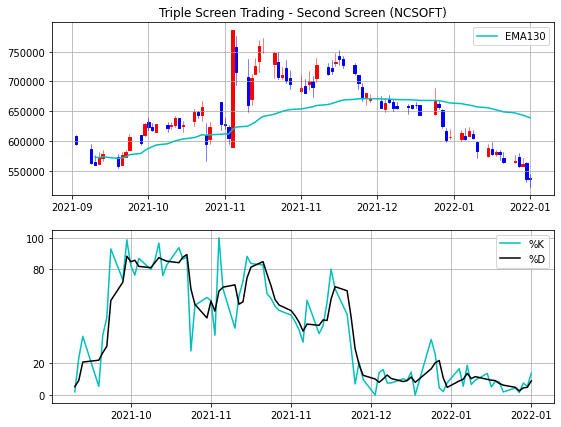

In [18]:
plt.figure(figsize=(9, 7))
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - Second Screen (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
plt.legend(loc='best')
p1 = plt.subplot(2, 1, 2)
plt.grid(True)
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color='c', label='%K')
plt.plot(df.number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100]) # ⑥
plt.legend(loc='best')
plt.show()